Classes: ['normal', 'tumor']


C:\Users\manav\AppData\Local\Temp\ipykernel_6728\3441435777.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=de

✅ Loaded model from efficientnetb0_best.pth
✅ Running on device: cuda


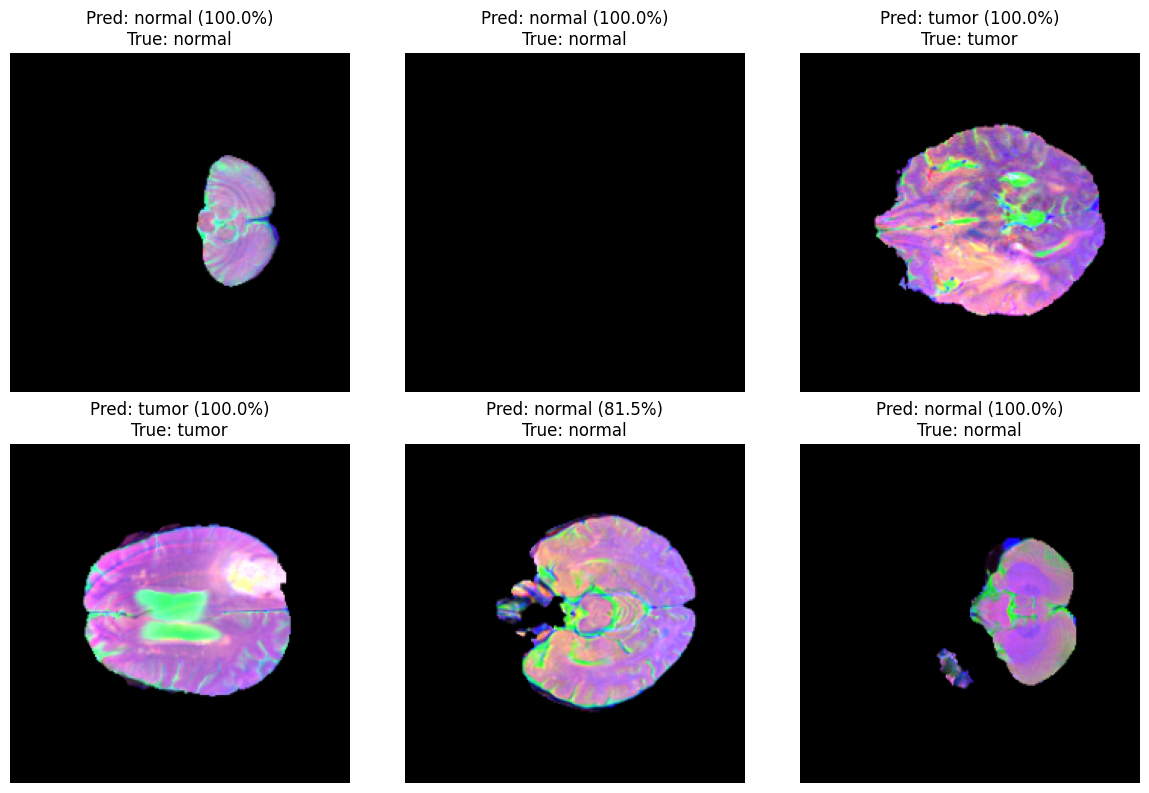

In [4]:
"""
inference_efficientnet_b0.py
Test your trained EfficientNetB0 model on random MRI slices.
"""

import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import os

# ----------------------------
# CONFIGURATION
# ----------------------------
DATA_DIR = r"C:\Users\manav\Documents\dataset_slices"
MODEL_PATH = "efficientnetb0_best.pth"
IMG_SIZE = 224
NUM_SAMPLES = 6  # number of images to visualize
USE_GPU = torch.cuda.is_available()
device = torch.device("cuda" if USE_GPU else "cpu")

# ----------------------------
# DATASET & TRANSFORMS
# ----------------------------
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_data = datasets.ImageFolder(os.path.join(DATA_DIR, 'val'), transform=transform)
val_loader = DataLoader(val_data, batch_size=1, shuffle=True)

class_names = val_data.classes
print(f"Classes: {class_names}")

# ----------------------------
# LOAD MODEL
# ----------------------------
model = models.efficientnet_b0(weights=None)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 2)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model = model.to(device)
model.eval()

print(f"✅ Loaded model from {MODEL_PATH}")
print(f"✅ Running on device: {device}")

# ----------------------------
# VISUALIZE PREDICTIONS
# ----------------------------
def imshow(img, title=None):
    img = img.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.axis("off")

fig = plt.figure(figsize=(12, 8))

# Randomly sample some images from the validation dataset
samples = random.sample(range(len(val_data)), NUM_SAMPLES)

for i, idx in enumerate(samples):
    img, label = val_data[idx]
    inputs = img.unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(inputs)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        pred_class = torch.argmax(probs, dim=1).item()
        confidence = probs[0][pred_class].item()

    ax = plt.subplot(2, 3, i + 1)
    title = f"Pred: {class_names[pred_class]} ({confidence*100:.1f}%)\nTrue: {class_names[label]}"
    imshow(img, title=title)

plt.tight_layout()
plt.show()


C:\Users\manav\AppData\Local\Temp\ipykernel_6728\2279658204.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=de

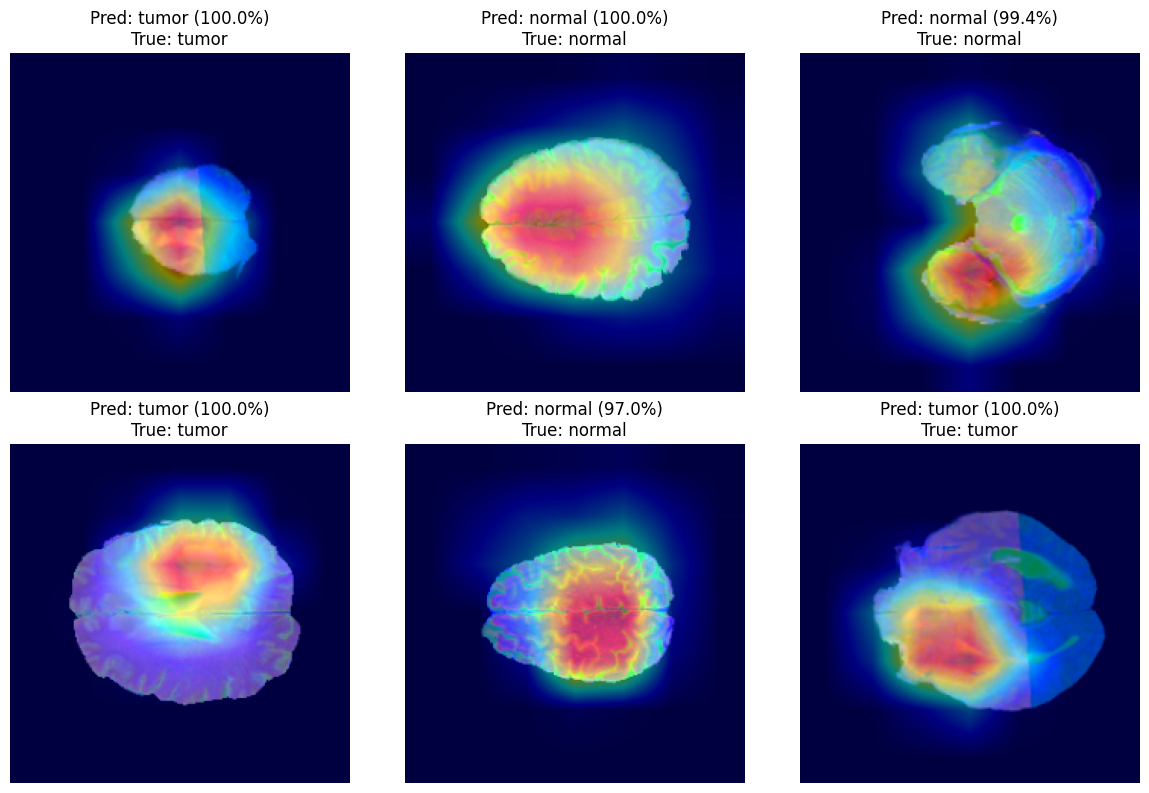

In [5]:
"""
gradcam_efficientnet_b0.py
Generate Grad-CAM visualizations for EfficientNetB0 tumor classifier.
"""

import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import os

# ----------------------------
# CONFIGURATION
# ----------------------------
DATA_DIR = r"C:\Users\manav\Documents\dataset_slices"
MODEL_PATH = "efficientnetb0_best.pth"
IMG_SIZE = 224
NUM_SAMPLES = 6
USE_GPU = torch.cuda.is_available()
device = torch.device("cuda" if USE_GPU else "cpu")

# ----------------------------
# TRANSFORMS & DATA
# ----------------------------
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
val_data = datasets.ImageFolder(os.path.join(DATA_DIR, "val"), transform=transform)
class_names = val_data.classes

# ----------------------------
# LOAD MODEL
# ----------------------------
model = models.efficientnet_b0(weights=None)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 2)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device).eval()

# ----------------------------
# GRAD-CAM IMPLEMENTATION
# ----------------------------
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx=None):
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        self.model.zero_grad()
        loss = output[0, class_idx]
        loss.backward()

        grads = self.gradients
        acts = self.activations

        weights = grads.mean(dim=(2, 3), keepdim=True)
        cam = (weights * acts).sum(dim=1, keepdim=True)
        cam = torch.relu(cam)
        cam = cam.squeeze().cpu().numpy()

        cam = cv2.resize(cam, (IMG_SIZE, IMG_SIZE))
        cam = (cam - cam.min()) / (cam.max() + 1e-8)
        return cam

# ----------------------------
# SETUP GRAD-CAM
# ----------------------------
target_layer = model.features[-1][0]  # last conv block of EfficientNetB0
gradcam = GradCAM(model, target_layer)

# ----------------------------
# VISUALIZATION
# ----------------------------
def show_cam_on_image(img_tensor, mask, title):
    img = img_tensor.cpu().numpy().transpose(1, 2, 0)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)

    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    overlay = np.float32(heatmap) / 255 + np.float32(img)
    overlay = overlay / np.max(overlay)

    plt.imshow(overlay)
    plt.title(title)
    plt.axis("off")

# ----------------------------
# SAMPLE INFERENCE & GRAD-CAM
# ----------------------------
samples = random.sample(range(len(val_data)), NUM_SAMPLES)
plt.figure(figsize=(12, 8))

for i, idx in enumerate(samples):
    img, label = val_data[idx]
    input_tensor = img.unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(input_tensor)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        pred_class = probs.argmax(dim=1).item()
        confidence = probs[0][pred_class].item()

    cam = gradcam.generate(input_tensor, pred_class)

    plt.subplot(2, 3, i + 1)
    title = f"Pred: {class_names[pred_class]} ({confidence*100:.1f}%)\nTrue: {class_names[label]}"
    show_cam_on_image(img, cam, title)

plt.tight_layout()
plt.show()
